In [1]:
import os
import datetime
import numpy as np
import tensorflow as tf
from data.cifar import CIFAR10, CIFAR100
from model import CoTeachingModel, coteach_loss, compute_pure_ratio
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

%load_ext autoreload
%autoreload 2

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13033251273177304817
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7798259712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8606153494923352043
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import random

def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_seed(42)

In [3]:
print_freq=100
# corruption rate, should be less than 1
noise_rate=0.5
forget_rate = None
if forget_rate is None:
    forget_rate = noise_rate

# how many epochs for linear drop rate, can be 5, 10,  15. This param is equal to Tk for R(T) in the paper.
num_gradual=10
# exponent of the forget rate, can be 0.5, 1, 2. This parameter is equal to c in Tc for R(T) in the paper.
exponent=1

# mnist, cifar10, or cifar100
dataset='cifar10'
# 'noise_type is [pairflip or symmetric]'
noise_type='symmetric'

if dataset == "cifar10":
    input_shape = [32, 32, 3]
    num_classes = 10
    epoch_decay_start = 80
    train_dataset = CIFAR10("./data/cifar10", download=True, train=True, noise_type=noise_type,
                            noise_rate=noise_rate)
    test_dataset = CIFAR10("./data/cifar10", download=True, train=False, noise_type=noise_type,
                           noise_rate=noise_rate)

elif dataset == "cifar100":
    input_shape = [32, 32, 3]
    num_classes = 100
    epoch_decay_start = 100
    train_dataset = CIFAR100("./data/cifar100", download=True, train=True, noise_type=noise_type,
                             noise_rate=noise_rate)
    test_dataset = CIFAR100("./data/cifar100", download=True, train=False, noise_type=noise_type,
                            noise_rate=noise_rate)

else:
    raise ValueError("Unsupported dataset...")


noise_or_not = train_dataset.noise_or_not

Files already downloaded and verified
Actual noise 0.50
Files already downloaded and verified


In [4]:
n_epoch=200
batch_size=128

epoch_decay_start=80
# Adjust learning rate for Adam Optimizer
learning_rate = 0.001
lr_plan = [learning_rate] * n_epoch
for i in range(epoch_decay_start, n_epoch):
    lr_plan[i] = float(n_epoch - i) / (n_epoch - epoch_decay_start) * learning_rate

# define drop rate schedule
forget_rate_schedule = np.ones(n_epoch) * forget_rate
forget_rate_schedule[:num_gradual] = np.linspace(0, forget_rate ** exponent, num_gradual)

# create training and testing batches
train_batches = train_dataset.batch_patcher(batch_size=batch_size, drop_last=True)
test_batches = test_dataset.batch_patcher(batch_size=batch_size, drop_last=True)

In [5]:
optimizer = tf.keras.optimizers.Adam()

def train_step(images, labels, lr, forget_rate):
    with tf.GradientTape(persistent=True) as tape:
        logits1, predicts1, logits2, predicts2 = coteach(images, training=True)
        acc1 = tf.reduce_mean(tf.cast(tf.equal(predicts1, tf.cast(labels, dtype=tf.int64)),
                                           dtype=tf.float32))
        acc2 = tf.reduce_mean(tf.cast(tf.equal(predicts2, tf.cast(labels, dtype=tf.int64)),
                                           dtype=tf.float32))
        # co-teaching loss
        loss1, loss2, ind1_update, ind2_update = coteach_loss(logits1, logits2, labels,
                                                                                  forget_rate)

    gradient1 = tape.gradient(loss1, coteach.cnn_model_1.trainable_variables)
    gradient2 = tape.gradient(loss2, coteach.cnn_model_2.trainable_variables)
    
    optimizer.learning_rate = lr
    optimizer.apply_gradients(zip(gradient1, coteach.cnn_model_1.trainable_variables))
    optimizer.apply_gradients(zip(gradient2, coteach.cnn_model_2.trainable_variables))
    
    # Remove TAPE to free up memory
    del tape
    return  acc1, acc2, loss1, loss2, ind1_update, ind2_update

def test_step(images, labels):
    logits1, predicts1, logits2, predicts2 = coteach(images, training=False)
    return predicts1, predicts2

In [6]:
coteach = CoTeachingModel(n_outputs=num_classes, batch_size=batch_size,
                              drop_rate=0.25, top_bn=False)

# Keep results for plotting
test_acc_results = []
label_precision_results = []
for epoch in range(1, n_epoch):
    lr = lr_plan[epoch]  # load learning rate for current epoch

    pure_ratio_1_list, pure_ratio_2_list = [], []
    train_total, train_correct1 = 0, 0
    train_total2, train_correct2 = 0, 0

    for i, (images, labels, indexes) in enumerate(train_batches):
        acc1, acc2, loss1, loss2, ind1, ind2 = train_step(images, labels, lr, forget_rate_schedule[epoch])

        pure_ratio_1, pure_ratio_2 = compute_pure_ratio(ind1, ind2, indexes, noise_or_not)
        pure_ratio_1_list.append(100 * pure_ratio_1)
        pure_ratio_2_list.append(100 * pure_ratio_2)
        train_total += 1
        train_correct1 += acc1
        train_correct2 += acc2

        if (i + 1) % print_freq == 0:
            print("Epoch [%d/%d], Iter [%d/%d], training acc1: %.4f%%, training acc2: %.4f%%, "
                  "train loss1: %.4f, train loss2: %.4f, pure_ratio_1: %.4f%%, pure_ratio_2: %.4f%%" %
                  (epoch, n_epoch, i + 1, len(train_batches), acc1 * 100.0, acc2 * 100.0, loss1, loss2,
                   sum(pure_ratio_1_list) / len(pure_ratio_1_list),
                   sum(pure_ratio_2_list) / len(pure_ratio_2_list)), flush=True)

    train_acc1 = train_correct1 / train_total * 100.0
    train_acc2 = train_correct2 / train_total * 100.0

    # testing
    print('Evaluating...')
    total, correct1, correct2 = 0, 0, 0
    for i, (images, labels, _) in enumerate(test_batches):
        pred1, pred2 = test_step(images, labels)
       
        labels = np.reshape(labels, newshape=(labels.shape[0], ))
        total += labels.shape[0]
        correct1 += np.sum(pred1 == labels)
        correct2 += np.sum(pred2 == labels)
    acc1 = 100 * float(correct1) / float(total)
    acc2 = 100 * float(correct2) / float(total)

    mean_pure_ratio1 = sum(pure_ratio_1_list) / len(pure_ratio_1_list)
    mean_pure_ratio2 = sum(pure_ratio_2_list) / len(pure_ratio_2_list)

    # End epoch
    test_acc_results.append(acc1)
    label_precision_results.append(mean_pure_ratio1)
    print('Epoch [%d/%d] Test Accuracy on the %s test images: Model1 %.4f%% Model2 %.4f%%, Pure Ratio 1 %.4f%%, '
          'Pure Ratio 2 %.4f%%\n' % (epoch, n_epoch, len(test_dataset), acc1, acc2, mean_pure_ratio1,
                                     mean_pure_ratio2), flush=True)

Epoch [1/200], Iter [100/390], training acc1: 23.4375%, training acc2: 18.7500%, train loss1: 2.0965, train loss2: 2.1144, pure_ratio_1: 52.7833%, pure_ratio_2: 52.7583%
Epoch [1/200], Iter [200/390], training acc1: 26.5625%, training acc2: 29.6875%, train loss1: 2.0700, train loss2: 2.0644, pure_ratio_1: 53.0333%, pure_ratio_2: 53.0125%
Epoch [1/200], Iter [300/390], training acc1: 30.4688%, training acc2: 25.0000%, train loss1: 1.9460, train loss2: 2.0193, pure_ratio_1: 53.4194%, pure_ratio_2: 53.4111%
Evaluating...
Epoch [1/200] Test Accuracy on the 10000 test images: Model1 42.5681% Model2 39.2027%, Pure Ratio 1 53.2970%, Pure Ratio 2 53.2991%

Epoch [2/200], Iter [100/390], training acc1: 24.2188%, training acc2: 26.5625%, train loss1: 1.9722, train loss2: 1.9744, pure_ratio_1: 56.2035%, pure_ratio_2: 56.1504%
Epoch [2/200], Iter [200/390], training acc1: 32.8125%, training acc2: 31.2500%, train loss1: 1.9060, train loss2: 1.9387, pure_ratio_1: 56.2743%, pure_ratio_2: 56.2655%
Epo

Epoch [13/200], Iter [300/390], training acc1: 52.3438%, training acc2: 50.7812%, train loss1: 0.1958, train loss2: 0.2562, pure_ratio_1: 90.5833%, pure_ratio_2: 90.6094%
Evaluating...
Epoch [13/200] Test Accuracy on the 10000 test images: Model1 75.7812% Model2 75.9916%, Pure Ratio 1 90.3766%, Pure Ratio 2 90.4207%

Epoch [14/200], Iter [100/390], training acc1: 47.6562%, training acc2: 50.0000%, train loss1: 0.3234, train loss2: 0.2374, pure_ratio_1: 90.5625%, pure_ratio_2: 90.6250%
Epoch [14/200], Iter [200/390], training acc1: 42.1875%, training acc2: 43.7500%, train loss1: 0.3437, train loss2: 0.4260, pure_ratio_1: 90.3984%, pure_ratio_2: 90.3906%
Epoch [14/200], Iter [300/390], training acc1: 52.3438%, training acc2: 50.7812%, train loss1: 0.2012, train loss2: 0.2101, pure_ratio_1: 90.7604%, pure_ratio_2: 90.6667%
Evaluating...
Epoch [14/200] Test Accuracy on the 10000 test images: Model1 76.1619% Model2 76.0517%, Pure Ratio 1 90.4688%, Pure Ratio 2 90.4688%

Epoch [15/200], Iter

Epoch [26/200], Iter [100/390], training acc1: 51.5625%, training acc2: 53.1250%, train loss1: 0.1177, train loss2: 0.1672, pure_ratio_1: 90.5000%, pure_ratio_2: 90.3281%
Epoch [26/200], Iter [200/390], training acc1: 52.3438%, training acc2: 49.2188%, train loss1: 0.0972, train loss2: 0.1654, pure_ratio_1: 90.3438%, pure_ratio_2: 90.1562%
Epoch [26/200], Iter [300/390], training acc1: 53.9062%, training acc2: 56.2500%, train loss1: 0.0650, train loss2: 0.0448, pure_ratio_1: 90.4635%, pure_ratio_2: 90.4010%
Evaluating...
Epoch [26/200] Test Accuracy on the 10000 test images: Model1 76.1218% Model2 77.5040%, Pure Ratio 1 90.2604%, Pure Ratio 2 90.1442%

Epoch [27/200], Iter [100/390], training acc1: 54.6875%, training acc2: 54.6875%, train loss1: 0.0284, train loss2: 0.0450, pure_ratio_1: 90.2656%, pure_ratio_2: 90.5625%
Epoch [27/200], Iter [200/390], training acc1: 52.3438%, training acc2: 51.5625%, train loss1: 0.0286, train loss2: 0.0234, pure_ratio_1: 90.0938%, pure_ratio_2: 90.351

Epoch [38/200], Iter [300/390], training acc1: 57.0312%, training acc2: 55.4688%, train loss1: 0.0756, train loss2: 0.0715, pure_ratio_1: 90.0156%, pure_ratio_2: 89.9219%
Evaluating...
Epoch [38/200] Test Accuracy on the 10000 test images: Model1 76.6727% Model2 77.2636%, Pure Ratio 1 89.7957%, Pure Ratio 2 89.6635%

Epoch [39/200], Iter [100/390], training acc1: 54.6875%, training acc2: 54.6875%, train loss1: 0.0426, train loss2: 0.0422, pure_ratio_1: 89.8906%, pure_ratio_2: 89.9219%
Epoch [39/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.1250%, train loss1: 0.0081, train loss2: 0.0536, pure_ratio_1: 89.6484%, pure_ratio_2: 89.6328%
Epoch [39/200], Iter [300/390], training acc1: 56.2500%, training acc2: 55.4688%, train loss1: 0.0996, train loss2: 0.0270, pure_ratio_1: 89.8906%, pure_ratio_2: 89.8542%
Evaluating...
Epoch [39/200] Test Accuracy on the 10000 test images: Model1 75.8814% Model2 76.7428%, Pure Ratio 1 89.6274%, Pure Ratio 2 89.6194%

Epoch [40/200], Iter

Epoch [51/200], Iter [100/390], training acc1: 54.6875%, training acc2: 55.4688%, train loss1: 0.0965, train loss2: 0.0105, pure_ratio_1: 89.2969%, pure_ratio_2: 89.5938%
Epoch [51/200], Iter [200/390], training acc1: 53.1250%, training acc2: 53.9062%, train loss1: 0.0327, train loss2: 0.0112, pure_ratio_1: 89.2500%, pure_ratio_2: 89.3828%
Epoch [51/200], Iter [300/390], training acc1: 58.5938%, training acc2: 57.0312%, train loss1: 0.0174, train loss2: 0.0149, pure_ratio_1: 89.7240%, pure_ratio_2: 89.6042%
Evaluating...
Epoch [51/200] Test Accuracy on the 10000 test images: Model1 77.0533% Model2 76.9631%, Pure Ratio 1 89.4832%, Pure Ratio 2 89.3550%

Epoch [52/200], Iter [100/390], training acc1: 54.6875%, training acc2: 53.9062%, train loss1: 0.0230, train loss2: 0.0163, pure_ratio_1: 89.4688%, pure_ratio_2: 89.5156%
Epoch [52/200], Iter [200/390], training acc1: 53.1250%, training acc2: 52.3438%, train loss1: 0.0231, train loss2: 0.0528, pure_ratio_1: 89.1250%, pure_ratio_2: 89.203

Epoch [63/200], Iter [300/390], training acc1: 57.8125%, training acc2: 57.0312%, train loss1: 0.0226, train loss2: 0.0240, pure_ratio_1: 89.3958%, pure_ratio_2: 89.4167%
Evaluating...
Epoch [63/200] Test Accuracy on the 10000 test images: Model1 77.2336% Model2 76.7127%, Pure Ratio 1 89.1466%, Pure Ratio 2 89.2027%

Epoch [64/200], Iter [100/390], training acc1: 53.9062%, training acc2: 55.4688%, train loss1: 0.0635, train loss2: 0.0069, pure_ratio_1: 89.3281%, pure_ratio_2: 89.3906%
Epoch [64/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0208, train loss2: 0.0133, pure_ratio_1: 89.0469%, pure_ratio_2: 89.0938%
Epoch [64/200], Iter [300/390], training acc1: 58.5938%, training acc2: 59.3750%, train loss1: 0.0050, train loss2: 0.0036, pure_ratio_1: 89.4010%, pure_ratio_2: 89.4010%
Evaluating...
Epoch [64/200] Test Accuracy on the 10000 test images: Model1 77.1334% Model2 77.8446%, Pure Ratio 1 89.2308%, Pure Ratio 2 89.1827%

Epoch [65/200], Iter

Epoch [76/200], Iter [100/390], training acc1: 55.4688%, training acc2: 55.4688%, train loss1: 0.0042, train loss2: 0.0072, pure_ratio_1: 88.9219%, pure_ratio_2: 88.7969%
Epoch [76/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.1250%, train loss1: 0.0015, train loss2: 0.0051, pure_ratio_1: 88.8281%, pure_ratio_2: 88.7344%
Epoch [76/200], Iter [300/390], training acc1: 58.5938%, training acc2: 57.0312%, train loss1: 0.0131, train loss2: 0.0660, pure_ratio_1: 89.1771%, pure_ratio_2: 89.1458%
Evaluating...
Epoch [76/200] Test Accuracy on the 10000 test images: Model1 77.5841% Model2 78.2552%, Pure Ratio 1 88.9583%, Pure Ratio 2 88.9864%

Epoch [77/200], Iter [100/390], training acc1: 55.4688%, training acc2: 54.6875%, train loss1: 0.0032, train loss2: 0.0678, pure_ratio_1: 89.2500%, pure_ratio_2: 88.8594%
Epoch [77/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.1250%, train loss1: 0.0055, train loss2: 0.0296, pure_ratio_1: 88.9609%, pure_ratio_2: 88.789

Epoch [88/200], Iter [300/390], training acc1: 58.5938%, training acc2: 58.5938%, train loss1: 0.0075, train loss2: 0.0119, pure_ratio_1: 89.1458%, pure_ratio_2: 89.3229%
Evaluating...
Epoch [88/200] Test Accuracy on the 10000 test images: Model1 76.9231% Model2 77.3037%, Pure Ratio 1 88.9503%, Pure Ratio 2 89.0745%

Epoch [89/200], Iter [100/390], training acc1: 55.4688%, training acc2: 54.6875%, train loss1: 0.0026, train loss2: 0.0285, pure_ratio_1: 88.6719%, pure_ratio_2: 88.9219%
Epoch [89/200], Iter [200/390], training acc1: 53.1250%, training acc2: 53.9062%, train loss1: 0.0190, train loss2: 0.0036, pure_ratio_1: 88.6328%, pure_ratio_2: 88.8828%
Epoch [89/200], Iter [300/390], training acc1: 57.8125%, training acc2: 57.8125%, train loss1: 0.0045, train loss2: 0.0347, pure_ratio_1: 89.0833%, pure_ratio_2: 89.2135%
Evaluating...
Epoch [89/200] Test Accuracy on the 10000 test images: Model1 77.0132% Model2 77.4639%, Pure Ratio 1 88.8181%, Pure Ratio 2 88.9103%

Epoch [90/200], Iter

Epoch [101/200], Iter [100/390], training acc1: 55.4688%, training acc2: 56.2500%, train loss1: 0.0029, train loss2: 0.0025, pure_ratio_1: 88.9219%, pure_ratio_2: 88.9375%
Epoch [101/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0005, train loss2: 0.0003, pure_ratio_1: 88.6562%, pure_ratio_2: 88.8672%
Epoch [101/200], Iter [300/390], training acc1: 59.3750%, training acc2: 57.0312%, train loss1: 0.0053, train loss2: 0.0015, pure_ratio_1: 89.0625%, pure_ratio_2: 89.1354%
Evaluating...
Epoch [101/200] Test Accuracy on the 10000 test images: Model1 77.5841% Model2 78.4155%, Pure Ratio 1 88.8502%, Pure Ratio 2 88.8542%

Epoch [102/200], Iter [100/390], training acc1: 55.4688%, training acc2: 55.4688%, train loss1: 0.0005, train loss2: 0.0001, pure_ratio_1: 88.6406%, pure_ratio_2: 88.6719%
Epoch [102/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0013, train loss2: 0.0032, pure_ratio_1: 88.5938%, pure_ratio_2: 

Epoch [113/200], Iter [300/390], training acc1: 58.5938%, training acc2: 59.3750%, train loss1: 0.0401, train loss2: 0.0012, pure_ratio_1: 88.9375%, pure_ratio_2: 88.8281%
Evaluating...
Epoch [113/200] Test Accuracy on the 10000 test images: Model1 78.1951% Model2 78.1250%, Pure Ratio 1 88.7139%, Pure Ratio 2 88.6538%

Epoch [114/200], Iter [100/390], training acc1: 56.2500%, training acc2: 55.4688%, train loss1: 0.0012, train loss2: 0.0010, pure_ratio_1: 88.5938%, pure_ratio_2: 88.8594%
Epoch [114/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0018, train loss2: 0.0010, pure_ratio_1: 88.4141%, pure_ratio_2: 88.7109%
Epoch [114/200], Iter [300/390], training acc1: 59.3750%, training acc2: 58.5938%, train loss1: 0.0026, train loss2: 0.0010, pure_ratio_1: 88.8177%, pure_ratio_2: 89.0521%
Evaluating...
Epoch [114/200] Test Accuracy on the 10000 test images: Model1 78.1751% Model2 78.4054%, Pure Ratio 1 88.5938%, Pure Ratio 2 88.8341%

Epoch [115/200

Epoch [126/200], Iter [100/390], training acc1: 55.4688%, training acc2: 55.4688%, train loss1: 0.0037, train loss2: 0.0008, pure_ratio_1: 88.2031%, pure_ratio_2: 88.7969%
Epoch [126/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0003, train loss2: 0.0002, pure_ratio_1: 88.2891%, pure_ratio_2: 88.5469%
Epoch [126/200], Iter [300/390], training acc1: 58.5938%, training acc2: 58.5938%, train loss1: 0.0005, train loss2: 0.0001, pure_ratio_1: 88.7760%, pure_ratio_2: 88.9219%
Evaluating...
Epoch [126/200] Test Accuracy on the 10000 test images: Model1 78.6058% Model2 77.8145%, Pure Ratio 1 88.5897%, Pure Ratio 2 88.7179%

Epoch [127/200], Iter [100/390], training acc1: 55.4688%, training acc2: 55.4688%, train loss1: 0.0010, train loss2: 0.0001, pure_ratio_1: 88.4844%, pure_ratio_2: 88.6250%
Epoch [127/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0045, train loss2: 0.0015, pure_ratio_1: 88.4844%, pure_ratio_2: 

Epoch [138/200], Iter [300/390], training acc1: 57.0312%, training acc2: 58.5938%, train loss1: 0.0625, train loss2: 0.0032, pure_ratio_1: 88.7812%, pure_ratio_2: 88.8750%
Evaluating...
Epoch [138/200] Test Accuracy on the 10000 test images: Model1 77.9347% Model2 78.3754%, Pure Ratio 1 88.6098%, Pure Ratio 2 88.6739%

Epoch [139/200], Iter [100/390], training acc1: 56.2500%, training acc2: 55.4688%, train loss1: 0.0004, train loss2: 0.0002, pure_ratio_1: 88.4219%, pure_ratio_2: 88.6406%
Epoch [139/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0004, train loss2: 0.0009, pure_ratio_1: 88.3281%, pure_ratio_2: 88.5469%
Epoch [139/200], Iter [300/390], training acc1: 58.5938%, training acc2: 58.5938%, train loss1: 0.0001, train loss2: 0.0003, pure_ratio_1: 88.6562%, pure_ratio_2: 88.8594%
Evaluating...
Epoch [139/200] Test Accuracy on the 10000 test images: Model1 78.3754% Model2 79.2869%, Pure Ratio 1 88.4255%, Pure Ratio 2 88.6538%

Epoch [140/200

Epoch [151/200], Iter [100/390], training acc1: 55.4688%, training acc2: 55.4688%, train loss1: 0.0005, train loss2: 0.0009, pure_ratio_1: 88.7500%, pure_ratio_2: 88.9531%
Epoch [151/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0031, train loss2: 0.0002, pure_ratio_1: 88.3594%, pure_ratio_2: 88.5703%
Epoch [151/200], Iter [300/390], training acc1: 58.5938%, training acc2: 58.5938%, train loss1: 0.0011, train loss2: 0.0003, pure_ratio_1: 88.7240%, pure_ratio_2: 88.9115%
Evaluating...
Epoch [151/200] Test Accuracy on the 10000 test images: Model1 77.8746% Model2 78.9563%, Pure Ratio 1 88.4896%, Pure Ratio 2 88.7059%

Epoch [152/200], Iter [100/390], training acc1: 56.2500%, training acc2: 55.4688%, train loss1: 0.0009, train loss2: 0.0001, pure_ratio_1: 88.5000%, pure_ratio_2: 88.8281%
Epoch [152/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0014, train loss2: 0.0001, pure_ratio_1: 88.2500%, pure_ratio_2: 

Epoch [163/200], Iter [300/390], training acc1: 59.3750%, training acc2: 58.5938%, train loss1: 0.0001, train loss2: 0.0008, pure_ratio_1: 88.7604%, pure_ratio_2: 88.7604%
Evaluating...
Epoch [163/200] Test Accuracy on the 10000 test images: Model1 79.2568% Model2 78.4956%, Pure Ratio 1 88.5737%, Pure Ratio 2 88.4976%

Epoch [164/200], Iter [100/390], training acc1: 56.2500%, training acc2: 55.4688%, train loss1: 0.0001, train loss2: 0.0001, pure_ratio_1: 88.6406%, pure_ratio_2: 88.6875%
Epoch [164/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0002, train loss2: 0.0002, pure_ratio_1: 88.4609%, pure_ratio_2: 88.4219%
Epoch [164/200], Iter [300/390], training acc1: 59.3750%, training acc2: 58.5938%, train loss1: 0.0000, train loss2: 0.0001, pure_ratio_1: 88.7604%, pure_ratio_2: 88.8646%
Evaluating...
Epoch [164/200] Test Accuracy on the 10000 test images: Model1 79.4171% Model2 78.8662%, Pure Ratio 1 88.4936%, Pure Ratio 2 88.5777%

Epoch [165/200

Epoch [176/200], Iter [100/390], training acc1: 56.2500%, training acc2: 55.4688%, train loss1: 0.0006, train loss2: 0.0049, pure_ratio_1: 88.5156%, pure_ratio_2: 88.5000%
Epoch [176/200], Iter [200/390], training acc1: 54.6875%, training acc2: 53.9062%, train loss1: 0.0002, train loss2: 0.0002, pure_ratio_1: 88.2344%, pure_ratio_2: 88.4375%
Epoch [176/200], Iter [300/390], training acc1: 58.5938%, training acc2: 58.5938%, train loss1: 0.0000, train loss2: 0.0000, pure_ratio_1: 88.6875%, pure_ratio_2: 88.7604%
Evaluating...
Epoch [176/200] Test Accuracy on the 10000 test images: Model1 78.9263% Model2 78.9764%, Pure Ratio 1 88.4535%, Pure Ratio 2 88.4495%

Epoch [177/200], Iter [100/390], training acc1: 56.2500%, training acc2: 55.4688%, train loss1: 0.0008, train loss2: 0.0000, pure_ratio_1: 88.4844%, pure_ratio_2: 88.5312%
Epoch [177/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0002, train loss2: 0.0000, pure_ratio_1: 88.2422%, pure_ratio_2: 

Epoch [188/200], Iter [300/390], training acc1: 60.1562%, training acc2: 58.5938%, train loss1: 0.0000, train loss2: 0.0006, pure_ratio_1: 88.7292%, pure_ratio_2: 88.6354%
Evaluating...
Epoch [188/200] Test Accuracy on the 10000 test images: Model1 79.3069% Model2 79.3069%, Pure Ratio 1 88.5457%, Pure Ratio 2 88.4135%

Epoch [189/200], Iter [100/390], training acc1: 56.2500%, training acc2: 55.4688%, train loss1: 0.0030, train loss2: 0.0000, pure_ratio_1: 88.7656%, pure_ratio_2: 88.5156%
Epoch [189/200], Iter [200/390], training acc1: 53.9062%, training acc2: 53.9062%, train loss1: 0.0000, train loss2: 0.0000, pure_ratio_1: 88.2891%, pure_ratio_2: 88.4141%
Epoch [189/200], Iter [300/390], training acc1: 59.3750%, training acc2: 58.5938%, train loss1: 0.0000, train loss2: 0.0000, pure_ratio_1: 88.7240%, pure_ratio_2: 88.7812%
Evaluating...
Epoch [189/200] Test Accuracy on the 10000 test images: Model1 79.2668% Model2 79.3069%, Pure Ratio 1 88.5016%, Pure Ratio 2 88.5056%

Epoch [190/200

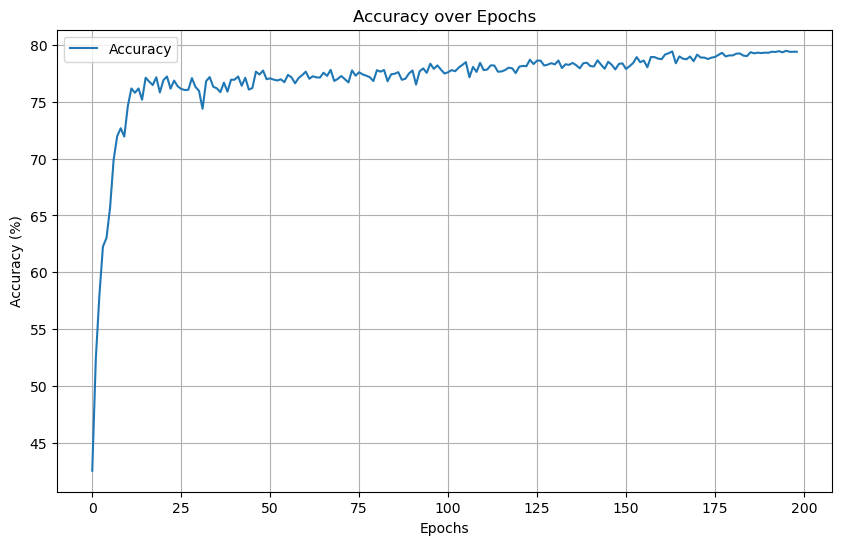

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(test_acc_results, linestyle='-', label='Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.legend()
plt.show()

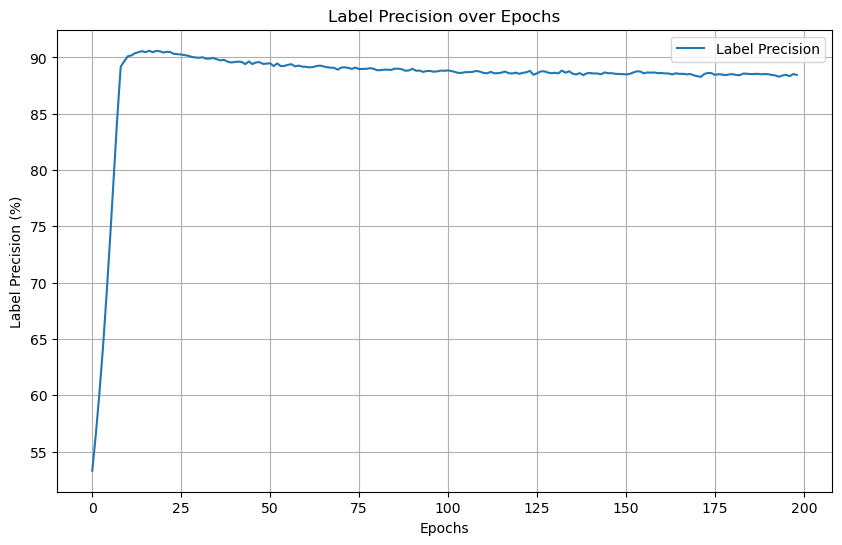

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(label_precision_results,  linestyle='-', label='Label Precision')
plt.title('Label Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Label Precision (%)')
plt.grid()
plt.legend()
plt.show()